In [28]:
from prototype import simulate_from_demography
import msprime
from dismal.multimodel import MultiModel
from dismal.models import im
import demesdraw
import demes
import prototype
import numpy as np
from scipy import stats
from quantile_forest import RandomForestQuantileRegressor
from sklearn.ensemble import RandomForestRegressor
import tqdm

## Without recombinatino

In [2]:
# build msprime demography
demography = msprime.Demography()
demography.add_population(name="anc", initial_size=100_000)
demography.add_population(name="A", initial_size=200_000)
demography.add_population(name="B", initial_size=50_000)
demography.add_population_split(time=200_000, ancestral="anc", derived=["A", "B"])
demography.set_migration_rate(source="B", dest="A", rate=1e-5)
demography.set_migration_rate(source="A", dest="B", rate=4e-5)
demesgraph = demography.to_demes()

<Axes: ylabel='time ago (generations)'>

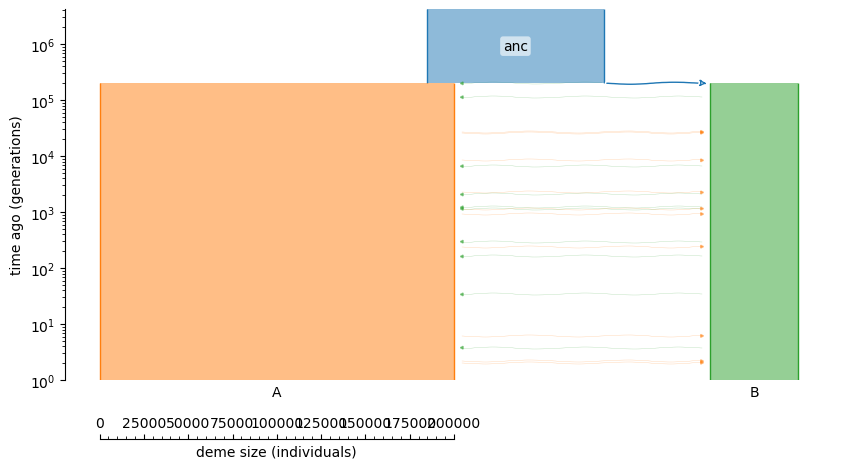

In [3]:
demesdraw.tubes(demesgraph, log_time=True, scale_bar=True)

In [4]:
blocklen = 500
num_blocks_per_state=[5000, 5000, 25000]
sparseS = simulate_from_demography(demography, blocklen=blocklen, mutation_rate=2e-8, recombination_rate=0, num_blocks_per_state=num_blocks_per_state)
S = sparseS.todense()[0]

In [5]:
s1 = S[0:blocklen]
s2 = S[blocklen:(blocklen*2)]
s3 = S[(blocklen*2):]

In [6]:
mod = im().fit_model(s1=s1, s2=s2, s3=s3)

In [7]:
mod.inferred_params

array([6.75822965, 1.19200675, 1.78961738, 0.65158672, 3.83026352,
       0.        ])

<Axes: ylabel='time ago (generations)'>

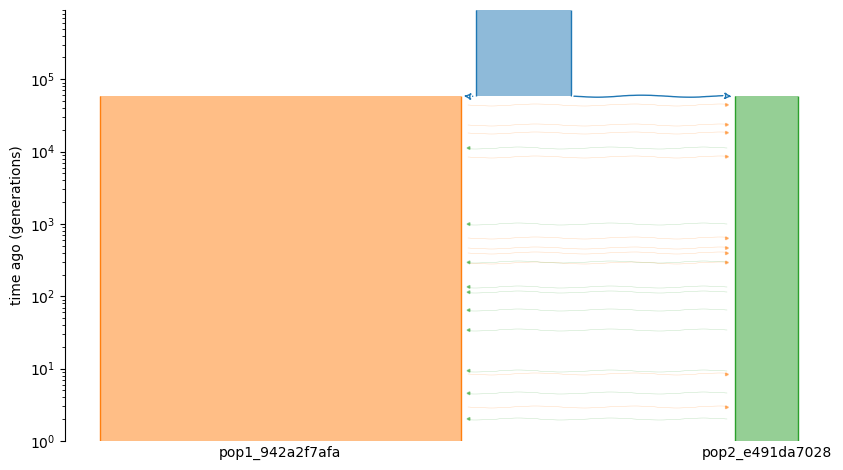

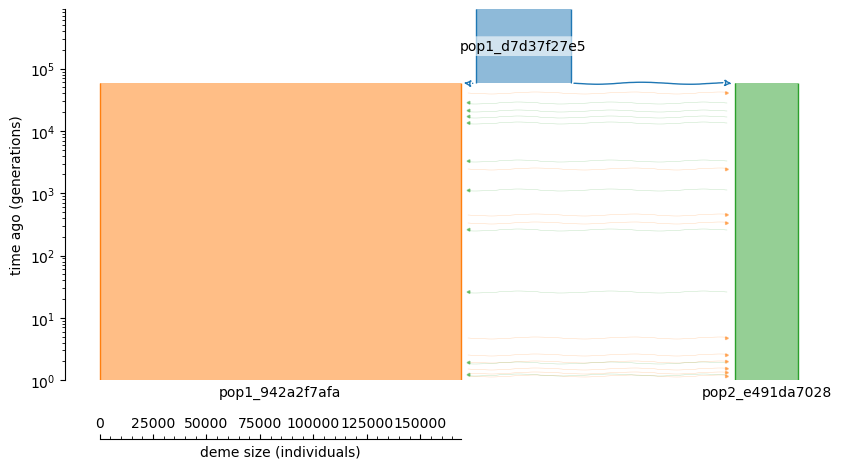

In [8]:
demesdraw.tubes(mod.demes_format(mutation_rate=2e-8, blocklen=blocklen).graph, log_time=True, scale_bar=True)

In [9]:
[deme.epochs[0].start_size for deme in mod.demes_representation.graph.demes]

[44740.43458786721, 168955.74129254636, 29800.168796720827]

In [10]:
[deme.epochs[0].start_time for deme in mod.demes_representation.graph.demes]

[inf, 58304.54583344533, 58304.54583344533]

In [11]:
mod.inferred_params

array([6.75822965, 1.19200675, 1.78961738, 0.65158672, 3.83026352,
       0.        ])

## Define priors

In [12]:
def M_prior(n):
    return stats.uniform.rvs(scale=0, loc=20, size=n)

def popsize_prior(n):
    return stats.uniform.rvs(scale=10_000, loc=1_000_000, size=n)

def time_prior(n):
    return stats.uniform.rvs(scale=10_000, loc=1_000_000, size=n)

## Generate embeddings

In [14]:
prototype.generate_reference_embeddings(blocklen=blocklen, mutation_rate=2e-8, recombination_rate=0, num_blocks_per_state=num_blocks_per_state,
                             popsizes_prior=popsize_prior, times_prior=time_prior, M_prior=M_prior,
                             num_sims_per_mod=25_000,
                             threads=-1, save_as="simple_im_embeddings_unif_prior")

Generating 25000 embeddings of 35000 blocks for models ['iso_2epoch', 'im'] using 7 threads
Model: iso_2epoch (1/2)


100%|██████████| 25000/25000 [8:04:20<00:00,  1.16s/it]  


Model: im (2/2)


100%|██████████| 25000/25000 [8:03:55<00:00,  1.16s/it]  


(array([[237., 205., 218., ...,   0.,   0.,   0.],
        [227., 234., 223., ...,   0.,   0.,   0.],
        [266., 243., 200., ...,   0.,   0.,   0.],
        ...,
        [185., 148., 136., ...,   0.,   0.,   0.],
        [184., 132., 109., ...,   0.,   0.,   0.],
        [171., 107.,  92., ...,   0.,   0.,   0.]]),
 array([[1009008.9960211 , 1001081.46418445, 1004892.2971822 ,
         1001890.00590323,       0.        ,       0.        ],
        [1003376.2242946 , 1009522.95782786, 1006772.87725598,
         1006579.05712383,       0.        ,       0.        ],
        [1008073.91983518, 1007594.45022053, 1008788.93510525,
         1000453.18941944,       0.        ,       0.        ],
        ...,
        [1003539.42114053, 1001895.54714916, 1007642.3635747 ,
         1002934.45562209,      20.        ,      20.        ],
        [1001263.44061121, 1005199.46098324, 1007930.81045817,
         1006441.4967507 ,      20.        ,      20.        ],
        [1001482.44961705, 1009

### Train model
Consider quantile-forest for future use; can also then use this for posterior estimation

In [18]:
arr = np.load("simple_im_embeddings_50Ksims.npz", allow_pickle=True)
X = arr["X"]
y_params = arr["y_params"]
y_models = arr["y_model"]

In [19]:
X = np.vstack([x.todense() for x in X])

In [29]:
rfqr = RandomForestQuantileRegressor(n_estimators=500,
                              default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              min_samples_leaf=5,
                              max_features="sqrt",
                              n_jobs=7)

rfqr.fit(X, y_params)

RandomForestQuantileRegressor(default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              max_features='sqrt', min_samples_leaf=5,
                              n_estimators=500, n_jobs=7)

## Simulate test data from model

In [21]:
sims = [prototype.simulate_from_demography(demography,
                                   blocklen=blocklen,
                                   mutation_rate=2e-8,
                                   recombination_rate=0,
                                   num_blocks_per_state=num_blocks_per_state) for _ in tqdm.tqdm(range(10))]

100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


In [30]:
X_pred = np.vstack([sim.todense() for sim in sims])

In [31]:
np.mean(rfqr.predict(X_pred), axis=0)

array([[ 74315.02923417, 134021.02505342, 237194.34967043,
        383466.6524637 , 573164.20962738],
       [ 21639.4623765 ,  38540.11819007,  61129.33295529,
         88649.51852477, 169160.11053529],
       [ 62557.53406057,  82629.87520437,  93968.13827123,
        105675.43806668, 136633.00483273],
       [  9285.2303309 ,  21449.4446765 ,  51326.96877681,
        142479.27773147, 305742.59947638],
       [     0.        ,      0.        ,      1.53133059,
             5.66031642,     11.23893316],
       [     0.        ,      0.        ,      2.24629763,
             6.20594743,     11.53650309]])

In [32]:
# comparing with regular rf
rfr = RandomForestRegressor(n_estimators=500, min_samples_leaf=5)
rfr.fit(X, y_params)
rfr.predict(X_pred)

array([[352469.81769801,  57897.1719172 , 108250.84959008,
        134590.32941863,      4.67337546,      5.73495066],
       [283620.61486064,  52918.36236674, 104482.9844923 ,
        157832.68160038,      4.91032587,      5.24281538],
       [327834.8036589 ,  56369.37792656, 103059.41555977,
        147643.41162954,      4.06064006,      5.0869766 ],
       [274230.24810748,  56022.66269039, 104521.99449803,
        158758.8483512 ,      4.63840177,      5.71707102],
       [252335.92744445,  53301.24015982, 103662.67980788,
        165959.14059375,      4.7889646 ,      5.39578138],
       [257831.54065281,  53262.72468116,  98956.22740874,
        178307.01713556,      5.12486612,      5.64172316],
       [305426.87727807,  52064.56311315, 102705.96092226,
        143032.09720057,      4.47227676,      5.22862172],
       [362853.15346782,  58504.51955273, 102167.65708717,
        153716.16236443,      4.78743828,      5.56122753],
       [398081.41002807,  60478.57597691, 134103

In [34]:
np.mean(rfr.predict(X_pred), axis=0)

array([311601.8601548 ,  55900.77484057, 112030.11655828, 162493.1473591 ,
            4.64632038,      5.54174523])

In [24]:
# build msprime demography
inferred_demography = msprime.Demography()
inferred_demography.add_population(name="anc", initial_size=92490)
inferred_demography.add_population(name="A", initial_size=239258)
inferred_demography.add_population(name="B", initial_size=62888)
inferred_demography.add_population_split(time=47191, ancestral="anc", derived=["A", "B"])
inferred_demography.set_migration_rate(source="B", dest="A", rate=5.9e-6)
inferred_demography.set_migration_rate(source="A", dest="B", rate=3.2e-5)
demesgraph = inferred_demography.to_demes()

<Axes: ylabel='time ago (generations)'>

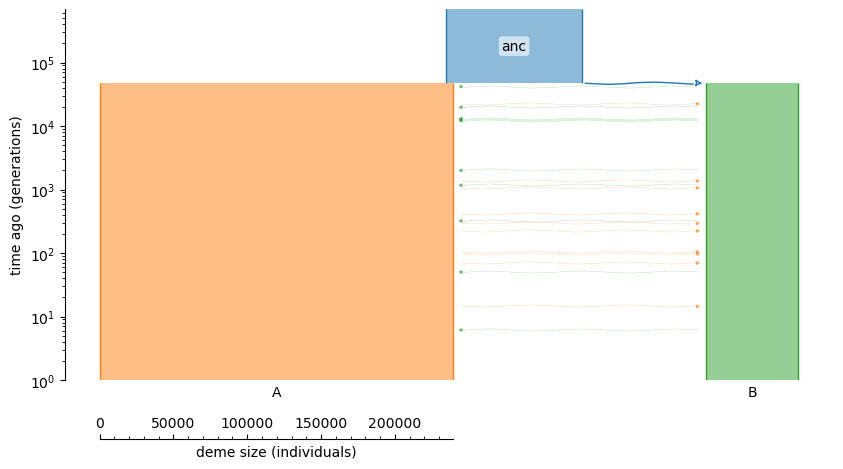

In [25]:
demesdraw.tubes(demesgraph, log_time=True, scale_bar=True)

## Does estimating parameters separately actually improve prediction?

Good test case: can we get better predictions of split time?


In [26]:
y[:, 3]

array([ 98907.0125258 , 117231.4770709 , 189381.85050845, ...,
       177559.63862849,  38935.26425487,   2358.41397567])

In [27]:
rfqr_split = RandomForestQuantileRegressor(n_estimators=500,
                              default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              min_samples_leaf=5,
                              max_features="sqrt",
                              n_jobs=7)

rfqr_split.fit(X, y[:,3])

RandomForestQuantileRegressor(default_quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                              max_features='sqrt', min_samples_leaf=5,
                              n_estimators=500, n_jobs=7)

In [35]:
np.mean(rfqr_split.predict(X_pred), axis=0)

array([  8794.15078645,  19336.02110721,  48806.30825809, 117359.44818972,
       257262.90822493])

That actually made predictions slightly worse